In [1]:
import tensorflow as tf
import numpy as np 
import  os 
from  random import shuffle
from tqdm import tqdm
tqdm.monitor_interval = 0
import cv2

In [2]:
Train_dir = r'E:\skin cancer detection\train'
Test_dir = r'E:\skin cancer detection\test'
IMG_SIZE = 50
LR = 0.0003


In [3]:
MODEL_NAME ='mvb-{}-{}.model'.format(LR, '2conv-basic-video')

In [4]:
def label_img(img):
    word_label = img[0]
    if word_label == 'm': return [1,0]
    elif word_label == 'b': return [0,1]

def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(Train_dir)):
        label = label_img(img)
        path = os.path.join(Train_dir,img)
        input_img = cv2.imread(path,cv2.IMREAD_COLOR)
        if input_img is not None:
            img = cv2.resize(input_img, (IMG_SIZE,IMG_SIZE))
            training_data.append([np.array(img), np.array(label)])
        else:
            print("image not loaded")


    shuffle(training_data)
    np.save('train_data.npy', training_data)
    return training_data

def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(Test_dir)):
        path = os.path.join(Test_dir, img)
        img_num = img.split('.')[0]
        img = cv2.resize(cv2.imread(path,cv2.IMREAD_GRAYSCALE),(IMG_SIZE,IMG_SIZE))
        testing_data.append([np.array(img), img_num])
        
    np.save('test_data.npy', testing_data)
    return testing_data

In [5]:
train_data = create_train_data()

 30%|███████████▋                           | 967/3230 [00:12<00:29, 76.53it/s]

image not loaded


100%|██████████████████████████████████████| 3230/3230 [01:39<00:00, 32.44it/s]


In [6]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

hdf5 is not supported on this machine (please install/reinstall h5py for optimal experience)
curses is not supported on this machine (please install/reinstall curses for an optimal experience)


In [7]:
tf.reset_default_graph()

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 3], name='input')

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)


convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir ='log')

Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [8]:
if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')

In [9]:
train = train_data[:-50]
test = train_data[-50:]

In [10]:
X = np.array([i[0] for i in train]).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
test_y = [i[1] for i in test]

In [11]:
model.fit({'input': X}, {'targets': Y}, n_epoch=20, validation_set=({'input': test_x}, {'targets': test_y}), snapshot_step=40, show_metric=True, run_id=MODEL_NAME)

Training Step: 999  | total loss: 0.24964 | time: 15.092s
| Adam | epoch: 020 | loss: 0.24964 - acc: 0.8865 -- iter: 3136/3179
Training Step: 1000  | total loss: 0.24768 | time: 16.395s
| Adam | epoch: 020 | loss: 0.24768 - acc: 0.8916 | val_loss: 0.39539 - val_acc: 0.7800 -- iter: 3179/3179
--


In [12]:
model.save(MODEL_NAME)

INFO:tensorflow:E:\skin cancer detection\mvb-0.0003-2conv-basic-video.model is not in all_model_checkpoint_paths. Manually adding it.


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 134.67it/s]


ValueError: Cannot feed value of shape (1, 50, 50) for Tensor 'input/X:0', which has shape '(?, 50, 50, 3)'

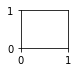

In [27]:
import matplotlib.pyplot as plt
test_data = process_test_data()
fig = plt.figure()
#test_data = np.load('test_data.npy')


for num, data in enumerate(test_data[16:20]):
    # malignant is 1:0, bengin is 0:1
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(5,6, num + 1)
    orig = img_data
#     data = img_data.reshape(51, 51, 3)
#     np.expand_dims(orig, axis=0)
    
    model_out = model.predict([orig])[0]
    
    if np.argmax(model_out) == 1: str_label='m'
    else: str_label = 'b'
        
    y.imshow(orig, cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()